In [1]:
import numpy as np
import torch
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
from preprocess import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fix random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)      
torch.cuda.manual_seed(0)
data_list = get_time_window_list(load_data(), 30)

In [2]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=False)
        
        # 全连接分类层
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # out: [batch, seq_len, hidden_dim]
        out = out[:, -1, :]  # 取最后时间步的输出
        out = self.fc(out)   # 分类
        return out

In [3]:
seq_len = 10
features = 310
num_classes = 3
batch_size = 32
epochs = 10

acc_list = []

# for i in [2]:
for i in range(12):

    X_train, Y_train, X_test, Y_test = merge_data(data_list, i)

    train_dataset = SeedDataset(X_train, torch.tensor(Y_train,dtype=torch.long), augment=False)
    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    test_dataset = SeedDataset(X_test, torch.tensor(Y_test,dtype=torch.long), augment=False)
    test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

    model = LSTMClassifier(input_dim=features, hidden_dim=64, num_layers=2, num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

    train_acc_list, test_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, total_loss = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * yb.size(0)
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
        train_acc = correct / total
        train_acc_list.append(train_acc)
        
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                pred = out.argmax(dim=1)
                correct += (pred == yb).sum().item()
                total += yb.size(0)
        test_acc = correct / total
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    acc_list.append(test_acc_list[-1])

    # plt.plot(range(1, epochs+1), train_acc_list, label='Train Acc', marker='o')
    # plt.plot(range(1, epochs+1), test_acc_list, label='Test Acc', marker='s')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.title('LSTM Training and Testing Accuracy')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4561, Test Acc: 0.3505
Epoch 2/10, Train Acc: 0.5814, Test Acc: 0.3333
Epoch 3/10, Train Acc: 0.6641, Test Acc: 0.2853
Epoch 4/10, Train Acc: 0.7409, Test Acc: 0.2853
Epoch 5/10, Train Acc: 0.8116, Test Acc: 0.3011
Epoch 6/10, Train Acc: 0.8687, Test Acc: 0.3011
Epoch 7/10, Train Acc: 0.9183, Test Acc: 0.3011
Epoch 8/10, Train Acc: 0.9573, Test Acc: 0.3011
Epoch 9/10, Train Acc: 0.9724, Test Acc: 0.3011
Epoch 10/10, Train Acc: 0.9790, Test Acc: 0.3011


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.5095, Test Acc: 0.4738
Epoch 2/10, Train Acc: 0.5948, Test Acc: 0.4724
Epoch 3/10, Train Acc: 0.6654, Test Acc: 0.4502
Epoch 4/10, Train Acc: 0.7294, Test Acc: 0.4401
Epoch 5/10, Train Acc: 0.7700, Test Acc: 0.3885
Epoch 6/10, Train Acc: 0.8100, Test Acc: 0.3326
Epoch 7/10, Train Acc: 0.8444, Test Acc: 0.3326
Epoch 8/10, Train Acc: 0.8820, Test Acc: 0.3333
Epoch 9/10, Train Acc: 0.9236, Test Acc: 0.3326
Epoch 10/10, Train Acc: 0.9531, Test Acc: 0.3319


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4781, Test Acc: 0.5054
Epoch 2/10, Train Acc: 0.5944, Test Acc: 0.6158
Epoch 3/10, Train Acc: 0.6634, Test Acc: 0.6158
Epoch 4/10, Train Acc: 0.7445, Test Acc: 0.6079
Epoch 5/10, Train Acc: 0.7980, Test Acc: 0.6315
Epoch 6/10, Train Acc: 0.8338, Test Acc: 0.6523
Epoch 7/10, Train Acc: 0.8719, Test Acc: 0.6946
Epoch 8/10, Train Acc: 0.9288, Test Acc: 0.7061
Epoch 9/10, Train Acc: 0.9627, Test Acc: 0.7211
Epoch 10/10, Train Acc: 0.9724, Test Acc: 0.7133


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4314, Test Acc: 0.4810
Epoch 2/10, Train Acc: 0.5929, Test Acc: 0.4573
Epoch 3/10, Train Acc: 0.6785, Test Acc: 0.5369
Epoch 4/10, Train Acc: 0.7501, Test Acc: 0.6194
Epoch 5/10, Train Acc: 0.7919, Test Acc: 0.6201
Epoch 6/10, Train Acc: 0.8267, Test Acc: 0.6237
Epoch 7/10, Train Acc: 0.8680, Test Acc: 0.6208
Epoch 8/10, Train Acc: 0.9082, Test Acc: 0.6022
Epoch 9/10, Train Acc: 0.9410, Test Acc: 0.5849
Epoch 10/10, Train Acc: 0.9649, Test Acc: 0.5928


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4525, Test Acc: 0.3900
Epoch 2/10, Train Acc: 0.6168, Test Acc: 0.4674
Epoch 3/10, Train Acc: 0.6898, Test Acc: 0.5835
Epoch 4/10, Train Acc: 0.7490, Test Acc: 0.5771
Epoch 5/10, Train Acc: 0.7977, Test Acc: 0.5835
Epoch 6/10, Train Acc: 0.8433, Test Acc: 0.6007
Epoch 7/10, Train Acc: 0.8825, Test Acc: 0.6115
Epoch 8/10, Train Acc: 0.9113, Test Acc: 0.6581
Epoch 9/10, Train Acc: 0.9364, Test Acc: 0.6502
Epoch 10/10, Train Acc: 0.9534, Test Acc: 0.6409


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4689, Test Acc: 0.3742
Epoch 2/10, Train Acc: 0.6032, Test Acc: 0.3950
Epoch 3/10, Train Acc: 0.6676, Test Acc: 0.3950
Epoch 4/10, Train Acc: 0.7129, Test Acc: 0.4323
Epoch 5/10, Train Acc: 0.7660, Test Acc: 0.4910
Epoch 6/10, Train Acc: 0.8085, Test Acc: 0.5326
Epoch 7/10, Train Acc: 0.8484, Test Acc: 0.5534
Epoch 8/10, Train Acc: 0.8873, Test Acc: 0.5599
Epoch 9/10, Train Acc: 0.9253, Test Acc: 0.5799
Epoch 10/10, Train Acc: 0.9546, Test Acc: 0.5885


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4542, Test Acc: 0.3864
Epoch 2/10, Train Acc: 0.5590, Test Acc: 0.4731
Epoch 3/10, Train Acc: 0.6464, Test Acc: 0.6423
Epoch 4/10, Train Acc: 0.7091, Test Acc: 0.6072
Epoch 5/10, Train Acc: 0.7908, Test Acc: 0.5993
Epoch 6/10, Train Acc: 0.8568, Test Acc: 0.6401
Epoch 7/10, Train Acc: 0.8965, Test Acc: 0.6337
Epoch 8/10, Train Acc: 0.9346, Test Acc: 0.6265
Epoch 9/10, Train Acc: 0.9629, Test Acc: 0.6086
Epoch 10/10, Train Acc: 0.9766, Test Acc: 0.6036


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.5047, Test Acc: 0.3699
Epoch 2/10, Train Acc: 0.6218, Test Acc: 0.5319
Epoch 3/10, Train Acc: 0.6706, Test Acc: 0.6595
Epoch 4/10, Train Acc: 0.7201, Test Acc: 0.6674
Epoch 5/10, Train Acc: 0.7770, Test Acc: 0.5792
Epoch 6/10, Train Acc: 0.8325, Test Acc: 0.5054
Epoch 7/10, Train Acc: 0.8787, Test Acc: 0.4724
Epoch 8/10, Train Acc: 0.9226, Test Acc: 0.4265
Epoch 9/10, Train Acc: 0.9557, Test Acc: 0.4251
Epoch 10/10, Train Acc: 0.9702, Test Acc: 0.4473


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4591, Test Acc: 0.4215
Epoch 2/10, Train Acc: 0.5885, Test Acc: 0.5656
Epoch 3/10, Train Acc: 0.6713, Test Acc: 0.5713
Epoch 4/10, Train Acc: 0.7406, Test Acc: 0.5735
Epoch 5/10, Train Acc: 0.7971, Test Acc: 0.5706
Epoch 6/10, Train Acc: 0.8693, Test Acc: 0.5857
Epoch 7/10, Train Acc: 0.9245, Test Acc: 0.6022
Epoch 8/10, Train Acc: 0.9592, Test Acc: 0.6179
Epoch 9/10, Train Acc: 0.9710, Test Acc: 0.6194
Epoch 10/10, Train Acc: 0.9808, Test Acc: 0.6208


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4335, Test Acc: 0.3950
Epoch 2/10, Train Acc: 0.5573, Test Acc: 0.4158
Epoch 3/10, Train Acc: 0.6525, Test Acc: 0.4158
Epoch 4/10, Train Acc: 0.7382, Test Acc: 0.4373
Epoch 5/10, Train Acc: 0.8001, Test Acc: 0.3634
Epoch 6/10, Train Acc: 0.8485, Test Acc: 0.3376
Epoch 7/10, Train Acc: 0.8862, Test Acc: 0.3233
Epoch 8/10, Train Acc: 0.9228, Test Acc: 0.3219
Epoch 9/10, Train Acc: 0.9548, Test Acc: 0.3348
Epoch 10/10, Train Acc: 0.9710, Test Acc: 0.3348


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4392, Test Acc: 0.3864
Epoch 2/10, Train Acc: 0.5389, Test Acc: 0.5505
Epoch 3/10, Train Acc: 0.6049, Test Acc: 0.5011
Epoch 4/10, Train Acc: 0.6744, Test Acc: 0.4265
Epoch 5/10, Train Acc: 0.7313, Test Acc: 0.3634
Epoch 6/10, Train Acc: 0.7879, Test Acc: 0.3484
Epoch 7/10, Train Acc: 0.8328, Test Acc: 0.3484
Epoch 8/10, Train Acc: 0.8749, Test Acc: 0.3484
Epoch 9/10, Train Acc: 0.9104, Test Acc: 0.3484
Epoch 10/10, Train Acc: 0.9452, Test Acc: 0.3484


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/10, Train Acc: 0.4344, Test Acc: 0.5276
Epoch 2/10, Train Acc: 0.5793, Test Acc: 0.6022
Epoch 3/10, Train Acc: 0.6570, Test Acc: 0.6495
Epoch 4/10, Train Acc: 0.7164, Test Acc: 0.6487
Epoch 5/10, Train Acc: 0.7732, Test Acc: 0.6401
Epoch 6/10, Train Acc: 0.8108, Test Acc: 0.6366
Epoch 7/10, Train Acc: 0.8564, Test Acc: 0.6323
Epoch 8/10, Train Acc: 0.8938, Test Acc: 0.6416
Epoch 9/10, Train Acc: 0.9269, Test Acc: 0.6545
Epoch 10/10, Train Acc: 0.9544, Test Acc: 0.6466


12
[0.3010752688172043, 0.3318996415770609, 0.7132616487455197, 0.592831541218638, 0.6408602150537634, 0.5885304659498208, 0.603584229390681, 0.44731182795698926, 0.6207885304659498, 0.3347670250896057, 0.34838709677419355, 0.646594982078853]
LOSO Mean Accuracy: 0.5142, Std: 0.1435


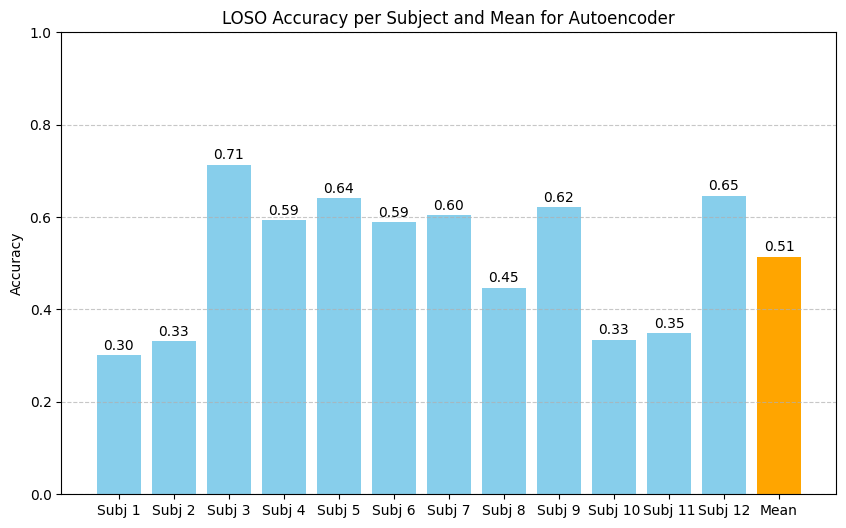

In [4]:
print(len(acc_list))

print(acc_list)
mean_acc = np.mean(acc_list)
std_acc = np.std(acc_list)
print(f"LOSO Mean Accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

x_labels = [f"Subj {i}" for i in range(1, 13)] + ["Mean"]
# 对应柱子高度
y_values = acc_list + [mean_acc]

# 绘制柱状图
plt.figure(figsize=(10,6))
bars = plt.bar(x_labels, y_values, color=['skyblue']*12 + ['orange'])

# 在柱子上显示数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("LOSO Accuracy per Subject and Mean for Autoencoder")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()